In [1]:
# Starter code (run this first)
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps


In [2]:
def load_image(filepath):
    """Loads an image into a numpy array.
    Note: image will have 3 color channels [r, g, b]."""
    img = np.float32(Image.open(filepath))
    #img = ImageOps.grayscale(img)
    return cv.normalize(img, None, 0, 255, cv.NORM_MINMAX).astype('uint8')
    #return (np.asarray(img).astype('uint8')/255)[:, :, :3]

In [3]:
sift = cv.SIFT_create() # sift detector uses difference of gaussian for feature detection

# get feature matches between two images using SIFT
def get_point_matches(img1, img2):
    """Returns matches as array: (feature track, image, coord)"""

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=10)
    search_params = dict(checks=100)
    flann = cv.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(des1, des2, k=2)
    good = []
    pts1 = []
    pts2 = []
    # ratio test as per Lowe's paper
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.85*n.distance:
            good.append(m)
            pts2.append(kp2[m.trainIdx].pt)
            pts1.append(kp1[m.queryIdx].pt)
        
    pts1 = np.int32(pts1)
    pts2 = np.int32(pts2)
    F, mask = cv.findFundamentalMat(pts1, pts2, cv.FM_LMEDS)
    # We select only inlier points
    pts1 = pts1[mask.ravel()==1]
    pts2 = pts2[mask.ravel()==1]
    
    pt1 = np.append(pts1[0],1)
    pt2 = np.append(pts2[0],1)
    epi_cnst = np.transpose(pt2)@F@pt1
    print("Epipolar constraint is ", epi_cnst)
    
    f = 0.05
    K1 = [[f, 0, img1.shape[0]/2],
     [0, f, img1.shape[1]/2],
     [0, 0, 1]]
    
    K2 = [[f, 0, img1.shape[0]/2 + .00918],
     [0, f, img1.shape[1]/2 + .00246],
     [0, 0, 1]]
    
    
    E_mat = np.transpose(K2)@F@K1
    u, s, vh = np.linalg.svd(E_mat, full_matrices=False)
    newE = u@np.eye(3)@np.transpose(vh)
    u, s, vh = np.linalg.svd(newE, full_matrices=False)
    
    W = np.eye(3)
    
    R1 = u@W@np.transpose(vh)
    R2 = u@np.transpose(W)@np.transpose(vh)
    print("u is ", u)
    
    u = np.array(u)
    t1 = u[:,-1]
    t2 = -u[:,-1]
    
    
    return np.stack((pts1, pts2), axis=1), pts1, pts2, F, R1, R2, t1, t2
# combine feature matches
def combine_matches(matches_a, matches_b):
    """Assumes that the 0'th image is the same between them."""
    combined_matches = []
    for ii in range(matches_a.shape[0]):
        ma0 = matches_a[ii, 0]
        # Find the match in b
        mi = np.where((matches_b[:, 0] == ma0).all(axis=1))[0]

        # If a match is found, add to the array
        if mi.size > 0:
            ma = matches_a[ii]
            mb = matches_b[int(mi[0])]
            combined_matches.append(np.concatenate(
                (ma, mb[1:]), axis=0))

    return np.array(combined_matches)



In [4]:
def visualize_matches(img_a, img_b, matches, ax=None):
    #if ax is None:
        #fig = plt.figure(figsize=(20,20))
        #ax = plt.gca()
    
    sa = img_a.shape
    sb = img_b.shape
    sp = 40
    off = sa[1]+sp
    
    merged_imgs = np.zeros(
        (max(sa[0], sb[0]), sa[1]+sb[1]+sp),
        dtype=np.float)
    merged_imgs[0:sa[0], 0:sa[1]] = img_a
    merged_imgs[0:sb[0], sa[1]+sp:] = img_b
    #ax.imshow(merged_imgs)
    
    #for m in matches:
        #ax.plot([m[0][0], m[1][0]+off], [m[0][1], m[1][1]], 'r', alpha=0.5)

def get_match_colors(image_c, combined_matches):
    colors = []
    nm = combined_matches.shape[0]
    for mi in range(nm):
        m = combined_matches[mi, 0, :]
        colors.append(image_c[m[1]-1:m[1]+2,
                              m[0]-1:m[0]+2].sum(axis=0).sum(axis=0)/9)
    
    return colors

In [5]:
def rectify_two(test1,test2,pts1,pts2, F):
    png = "1.png"
    h1,w1 = test1.shape
    h2,w2 = test2.shape
    _, H1, H2 = cv.stereoRectifyUncalibrated(np.float32(pts1), np.float32(pts2), F, imgSize=(w1,h1))
    
    img1_rectified = cv.warpPerspective(test1, H1, (w1,h1))
    img2_rectified = cv.warpPerspective(test2, H2, (w2,h2))
    
    #fig, axes = plt.subplots(1,2, figsize=(15, 10))
    #axes[0].imshow(img1_rectified, cmap="gray")
    #axes[1].imshow(img2_rectified, cmap='gray')
    #axes[0].axhline(400)
    #axes[1].axhline(400)
    #axes[0].axhline(600)
    #axes[1].axhline(600)

    
    return img1_rectified, img2_rectified

In [6]:
def set_points(three_images_arr, i, depth_map):
    if len(three_images_arr) != 3:
        raise ValueError('Array must have 3 images')
    test1 = cv.imread(three_images_arr[0],0)
    test2 = cv.imread(three_images_arr[1],0)
    test3 = cv.imread(three_images_arr[2],0)
    matches1, pts1,pts2,F,R1,R2,t1,t2 = get_point_matches(test1, test2)
    matches2, pts1_1,pts2_1,F_1,R1_1,R2_1,t1_1,t2_1 = get_point_matches(test1, test3)
    
    visualize_matches(test1, test2, matches1, ax=None)
    visualize_matches(test1, test3, matches2, ax=None)
    
    img1_rectified, img2_rectified = rectify_two(test1,test2,pts1,pts2, F)
    img1_rectified, img3_rectified = rectify_two(test1,test3,pts1_1,pts2_1, F_1)
    
    combined_matches = combine_matches(np.array(matches1), np.array(matches2)) 
    colors = get_match_colors(load_image(three_images_arr[0]), combined_matches)

    return combined_matches, colors, img1_rectified, img2_rectified, img3_rectified, R1,R2,t1,t2,R1_1,R2_1,t1_1,t2_1 

In [7]:
test1 = load_image('./world_rotate/trans_01.png')
#fig1 = plt.figure()
#plt.imshow(test1[:, :, 0])

#fig2 = plt.figure()
test2 = load_image('./world_rotate/trans_02.png')
#plt.imshow(test2[:, :, 0])

#fig3 = plt.figure()
test3 = load_image('./world_rotate/trans_03.png')
#plt.imshow(test3[:, :, 0])

depth_map = cv.imread('./world_rotate/depth_map_world.png')
depth_map = cv.cvtColor(depth_map, cv.COLOR_BGR2GRAY)

#fig1 = plt.figure()
#plt.imshow(depth_map)

In [8]:
three_images =  ['./world_rotate/trans_01.png','./world_rotate/trans_02.png','./world_rotate/trans_03.png']
X, colors, img1_rectified, img2_rectified, img3_rectified, R1,R2,t1,t2, R1_1,R2_1,t1_1,t2_1 = set_points(three_images, 0, depth_map)

Epipolar constraint is  -0.006032048915757926
u is  [[-1.77992450e-01 -9.83968284e-01  1.11849973e-02]
 [-9.82082748e-01  1.78343474e-01  6.08858079e-02]
 [ 6.19044752e-02  1.47378715e-04  9.98082068e-01]]
Epipolar constraint is  -0.014964823868387267
u is  [[-9.97275062e-01 -2.98386356e-02  6.74692945e-02]
 [ 7.37729259e-02 -4.04263743e-01  9.11662427e-01]
 [ 7.26265829e-05  9.14155612e-01  4.05363433e-01]]


In [9]:
def get_depth(img1_rectified, img2_rectified):
# CALCULATE DISPARITY (DEPTH MAP)
    # Matched block size. It must be an odd number >=1 . Normally, it should be somewhere in the 3..11 range.
    block_size = 11
    min_disp = -128
    max_disp = 128
    # Maximum disparity minus minimum disparity. The value is always greater than zero.
    # In the current implementation, this parameter must be divisible by 16.
    num_disp = max_disp - min_disp
    # Margin in percentage by which the best (minimum) computed cost function value should "win" the second best value to consider the found match correct.
    # Normally, a value within the 5-15 range is good enough
    uniquenessRatio = 5
    # Maximum size of smooth disparity regions to consider their noise speckles and invalidate.
    # Set it to 0 to disable speckle filtering. Otherwise, set it somewhere in the 50-200 range.
    speckleWindowSize = 0
    # Maximum disparity variation within each connected component.
    # If you do speckle filtering, set the parameter to a positive value, it will be implicitly multiplied by 16.
    # Normally, 1 or 2 is good enough.
    speckleRange = 2
    disp12MaxDiff = 0

    stereo = cv.StereoSGBM_create(
        minDisparity=min_disp,
        numDisparities=num_disp,
        blockSize=block_size,
        uniquenessRatio=uniquenessRatio,
        speckleWindowSize=speckleWindowSize,
        P1=8 * 1 * block_size * block_size,
        P2=32 * 1 * block_size * block_size,
    )
    
    disp = stereo.compute(np.uint8(img1_rectified), np.uint8(img2_rectified)).astype(np.float32)
    disp = cv.normalize(disp, disp, alpha=255, beta=0, norm_type=cv.NORM_MINMAX)
    disp = np.uint8(disp)

    b = 9.51066800099
    f = 0.05
    
    #fig = plt.figure()
    #plt.imshow(disp)
get_depth(img1_rectified, img2_rectified)

In [10]:
def get_depth_2(img1_rectified, img2_rectified):
    stereoSGBM = cv.StereoSGBM_create(minDisparity=0, 
                                   numDisparities = 64,
                                   blockSize = 3,
                                   P1 = 8*1*3*3, 
                                   P2 = 32*1*3*3
                                  )
    dispSGBM = stereoSGBM.compute(img1_rectified, img2_rectified).astype(np.float32) / 16
    #fig1 = plt.figure()
    #plt.imshow(dispSGBM, 'gray')
    #plt.colorbar()
    
    stereoBM = cv.StereoBM_create(numDisparities=16, blockSize=15)
    dispBM = stereoBM.compute(img1_rectified, img2_rectified)
    
    #fig2 = plt.figure()
    #plt.imshow(dispBM, 'gray')
    #plt.colorbar()
dispSGBM_1 = get_depth_2(img1_rectified, img2_rectified)

dispSGBM_2 = get_depth_2(img2_rectified, img3_rectified)

In [22]:
#Camera measurements in Blender
#distance from lens to surface of sphere = 9.5104
#distance from principal point to surface of sphere = 10.6558
#15 degrees in radians is 0.261799

#translation when rotating 15 degrees around the z-axis
#x = 9.5144*cos(0.261799) = 9.1863419329
#y = 9.5144*sin(0.261799) = 2.46250435877

#9.51066800099 = baseline

import os

for filename in os.listdir(directory):
    if filename.endswith(".asm") or filename.endswith(".py"): 
         # print(os.path.join(directory, filename))
        continue
    else:
        continue
b = 35.9 
f = 188.9 

# Camera matrix
K = [[f, 0, img1_rectified.shape[0]/2],
     [0, f, img1_rectified.shape[1]/2],
     [0, 0, 1]]
R = np.eye(3)
ta = [[0],[0],[1]]
Pa = K @ np.concatenate((R, ta), axis=1)

R = [[np.cos(0.261799),-np.sin(0.261799),0],
     [np.sin(0.261799),np.cos(0.261799),0],
     [0,0,1]]     
tb = [[34.720032502], [9.3071030883], [0]] 
Pb = K @ np.concatenate((R, tb), axis=1)


def solve_point_triangulation(proj_points, proj_matrices):
    # First we build the matrix
    D = np.zeros((2*len(proj_points), 4), dtype=float)
    for ii, (p, P) in enumerate(zip(proj_points, proj_matrices)):
        D[2*ii + 0] = p[1] * P[2] - P[1]
        D[2*ii + 1] = P[0] - p[0] * P[2]
        
    # Now, solve
    u, s, vh = np.linalg.svd(D, full_matrices=False)
    X = vh[np.argmin(s)]
    return X/X[3]

pa = X[:,0].tolist()
pb = X[:,1].tolist()

X0_rec = np.empty([len(pa),3])
for pta,ptb in zip(pa,pb):
    pt = solve_point_triangulation([pta,ptb], [Pa, Pb])[:-1]
    X0_rec = np.append(X0_rec,np.array([pt]),axis=0)

R1 is  [[ 0.96101001  0.17799245  0.21160919]
 [-0.15995579  0.98208275 -0.09963745]
 [ 0.22555244 -0.06190448 -0.97226227]]
t1 is  [[-0.011184997274914944], [-0.06088580787489762], [-0.9980820678858934]]
Pa is  [[5.0e-02 0.0e+00 5.4e+02 5.4e+02]
 [0.0e+00 5.0e-02 9.6e+02 9.6e+02]
 [0.0e+00 0.0e+00 1.0e+00 1.0e+00]]
Pb is  [[ 1.21846371e+02 -3.34195170e+01 -5.25011048e+02 -5.38964876e+02]
 [ 2.16522349e+02 -5.93791920e+01 -9.33376766e+02 -9.58161829e+02]
 [ 2.25552445e-01 -6.19044752e-02 -9.72262275e-01 -9.98082068e-01]]


IndexError: invalid index to scalar variable.

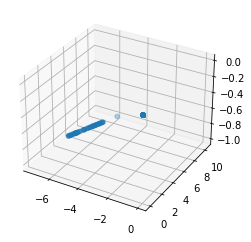

In [13]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X0_rec[:, 0], X0_rec[:, 1], X0_rec[:, 2])
plt.show()

In [14]:
depth_map = cv.imread('./world_rotate/depth_map_world.png',0)
#(1080, 1920, 3)
#540, 960
print(depth_map[0][0])
print(depth_map[540][960])
#plt.imshow(depth_map)

height, width = depth_map.shape
#mask = np.where(depth_map < 200)
#x = mask[1]
#y = mask[0]

#normalized_x = (x.astype(np.float32) - width * .5)/width
#normalized_y = (y.astype(np.float32) - height * .5)/ height

#div = .5 / np.tan(50 * .5)
#world_x = normalized_x * depth_map[y,x] / div
#world_y = normalized_x * depth_map[y,x] / div
#world_z = depth_map[y,x] 
#ones = np.ones(world_z.shape[0], dtype=np.float32)

#pcloud = np.vstack((world_x,world_y,world_z)).T


pt_cloud = []
x_center = 960
y_center = 540
foc_l = .05
X_s = []
Z_s = []
Y_s = []
for u in range(0,height):
    for v in range(0,width):
        Y = depth_map[u][v]
        if Y < 204:
            if foc_l > 0 and Y > 0:
                Z = (v - x_center) * Y / (Y / foc_l)
                X = (u - y_center) * Y / (Y / foc_l)
            else:
                Z = 0
                X = 0
        
            Z_s.append(Z)
            X_s.append(X)
            Y_s.append(Y)

    
    


206
101


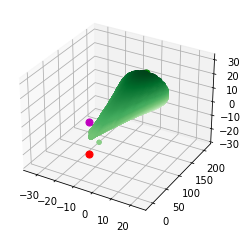

In [15]:
def diff(x,y):
    if(x > y):
        if(y<0):
            z = x+y
        else:
            z = x-y
    elif(y > x):
        if(x<0):
            z = x+y
        else:
            z = y-x
    return z/2

fig1 = plt.figure()
ax = plt.axes(projection='3d')
#Y_s = np.multiply(-1,Y_s)
ax.scatter3D(X_s,Y_s,Z_s,c=Z_s,cmap='Greens',s=15)

if(min(Y_s)>0):
    Y_s_pt = min(Y_s) + 3
else:
    Y_s_pt = min(Y_s) - 3
    
ax.scatter(diff(max(X_s),min(X_s)), Y_s_pt, min(Z_s), c='r', marker='o', s=50)
ax.scatter(diff(max(X_s),min(X_s)), Y_s_pt, max(Z_s), c='m', marker='o', s=50)

ax.scatter(diff(max(X_s),min(X_s)), max(Y_s), min(Z_s), c='y', marker='o', s=50)
ax.scatter(diff(max(X_s),min(X_s)), max(Y_s), max(Z_s), c='g', marker='o', s=50)

ax.set_xlim3d([min(X_s)-20, max(X_s)+20])
ax.set_ylim3d([min(Y_s)-20, max(Y_s)+20])
ax.set_zlim3d([min(Z_s)-20, max(Z_s)+20])

#ax.scatter(diff(max(X_s),min(X_s)), 0, min(Z_s), c='r', marker='o')
plt.show()

In [31]:
from scipy.spatial.transform import Rotation as R

rotation_degrees = 5
rotation_radians = np.radians(rotation_degrees)
rotation_axis = np.array([0, 0, 1])

rotation_vector = rotation_radians * rotation_axis
rotation = R.from_rotvec(rotation_vector)

pts_rot = []

pts = list(zip(X_s,Y_s,Z_s))
pts = [np.array(i) for i in pts]


In [23]:
from math import pi ,sin, cos

if(min(Y_s)>0):
    Y_s_pt = min(Y_s) + 3
else:
    Y_s_pt = min(Y_s) - 3

P1 = [diff(max(X_s),min(X_s)), max(Y_s), min(Z_s)]
P2 = [diff(max(X_s),min(X_s)), max(Y_s), max(Z_s)]

u = np.array(P2)-np.array(P1)

L = u[0]**2 + u[1]**2 + u[2]**2

#https://stackoverflow.com/questions/17763655/rotation-of-a-point-in-3d-about-an-arbitrary-axis-using-python
#https://docs.google.com/viewer?a=v&pid=sites&srcid=ZGVmYXVsdGRvbWFpbnxnbGVubm11cnJheXxneDoyMTJiZTZlNzVlMjFiZTFi
def R(theta, u, L, x):
    
    a = (u[0]**2 + (u[1]**2+u[2]**2)*cos(theta))/L
    b = (u[0]*u[1]*(1-cos(theta))-u[2]*np.sqrt(L)*sin(theta))/L
    c = (u[0]*u[2]*(1-cos(theta))+u[1]*np.sqrt(L)*sin(theta))/L
    d = (P1[0]*(u[1]**2+u[2]**2)-u[0]*(P1[1]*u[1]+P1[2]*u[2]))*(1-cos(theta))+(P1[1]*u[2]-P1[2]*u[1])*np.sqrt(L)*sin(theta)

    e = (u[0]*u[1]*(1-cos(theta))+u[2]*np.sqrt(L)*sin(theta))/L
    f = (u[1]**2 + (u[0]**2+u[2]**2)*cos(theta))/L
    g = (u[1]*u[2]*(1-cos(theta))-u[0]*np.sqrt(L)*sin(theta))/L
    h = (P1[1]*(u[0]**2+u[2]**2)-u[1]*(P1[0]*u[0]+P1[2]*u[2]))*(1-cos(theta))+(P1[2]*u[0]-P1[0]*u[2])*np.sqrt(L)*sin(theta)

    i = (u[0]*u[2]*(1-cos(theta))-u[1]*np.sqrt(L)*sin(theta))/L
    j = (u[1]*u[2]*(1-cos(theta))-u[0]*np.sqrt(L)*sin(theta))/L
    k = (u[2]**2 + (u[0]**2+u[1]**2)*cos(theta))/L
    l = (P1[2]*(u[0]**2+u[1]**2)-u[2]*(P1[0]*u[0]+P1[1]*u[1]))*(1-cos(theta))+(P1[0]*u[1]-P1[1]*u[0])*np.sqrt(L)*sin(theta)

    x = np.append(x,1)
    return x @ [[a,b,c,d],
            [e,f,g,h],
            [i,j,k,l],
           [0,0,0,1]] 

pts_rot = []
for i in range(0,len(X_s)):
    pts_rot.append(R(5,u,L,pts[i].T)[:-1].tolist())
pts_rot = np.array(pts_rot)

In [32]:
for i in range(0,len(X_s)):
    pts_rot.append(rotation.apply(pts[i].T).tolist())
pts_rot = np.array(pts_rot)

In [33]:
X_s_1 = pts_rot[:,0]
Y_s_1 = pts_rot[:,1]
Z_s_1 = pts_rot[:,2]

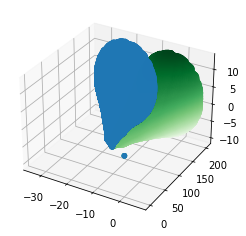

In [35]:
fig2 = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X_s,Y_s,Z_s,c=Z_s,cmap='Greens')
ax.scatter3D(X_s_1,Y_s_1,Z_s_1, cmap='Blues')
plt.show()